## initial setups

In [1]:
import pyomo.environ as pyo
solver = pyo.SolverFactory('glpk')

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False



# Simple 3-bus case

## case
In that case, Bus 1 and bus 2 are in the same substation. Line 1-2 is the internal connection: if it (say its breaker) is open, there are 2 nodes else only 1.

![myimage.png](./simple%203%20bus%20case.svg)

## Model

cost to minimize = $\sum{ls_i} - \alpha * br$ (load shedding bus $i$: $ls_i$. breaker state : $br=1$ if closed, $br=0$ if open)

$|\theta_2 - \theta_1| \le (1-br) \times M$

### case $br = 0 \implies \theta_1 \neq \theta_2$

$ P_{0i} = b_{0i} \theta_i = P_i^* = P_i - ls_i \le \overline{P_{0i}} \implies P_i - ls_i - br.M \le \overline{P_{0i}}$

$ 0 \le ls_i \le P_i $

### case $br = 1 \implies \theta_1 = \theta_2 = \theta $

$ \theta = \frac{P_{01}^* + P_{02}^*}{b_{01} + b_{02}}$ 

$ b_{0i}\theta_i \leq \overline{P_{0i}} \implies b_{0i} . \frac{P_1 + P_2 - ls_1 - ls_2}{b_{01} + b_{02}} - (1-br)M \leq \overline{P_{0i}} $



In [2]:
def build_model(P01M, P02M, P1, P2, b01, b02):
    bM = 1e3

    model = pyo.ConcreteModel()
    model.ls1 = pyo.Var(bounds = (0, P1), domain = pyo.NonNegativeReals)
    model.ls2 = pyo.Var(bounds = (0, P2), domain = pyo.NonNegativeReals)
    model.br = pyo.Var(domain = pyo.Binary)

    def constr_br_open(p, ls, br, bM, p_max):
        return p - ls - br * bM <= p_max

    def constr_br_close(p1, p2, ls1, ls2, b01, b02, br, bM, p_max):
        return b01 / (b01 + b02) * (p1 + p2 - ls1 - ls2) - (1 - br) * bM <= p_max

    model.const_open1 = pyo.Constraint(rule = constr_br_open(P1, model.ls1, model.br, bM, P01M))
    model.const_open2 = pyo.Constraint(rule = constr_br_open(P2, model.ls2, model.br, bM, P02M))
    model.const_close1 = pyo.Constraint(rule = constr_br_close(P1, P2, model.ls1, model.ls2, b01, b02, model.br, bM, P01M))
    model.const_close2 = pyo.Constraint(rule = constr_br_close(P1, P2, model.ls1, model.ls2, b02, b01, model.br, bM, P02M))

    model.obj = pyo.Objective(rule = model.ls1 + model.ls2 - model.br/1000, sense = pyo.minimize) # - model.br['br'] / bM
    return model
# solver.solve(model)


## results

### ploting functions

#### boundary lines
if $br=0$, the boundary line is  $P_{0i} = \overline{P_{0i}}$

if $br=1$, then 

$$
\begin{pmatrix} P_{01} \\ P_{02} \\ P_{12} \end{pmatrix}
= \frac{1}{b_{01} + b_{02}}
	\begin{pmatrix}
		b_{01} & b_{01} \\ b_{02} & b_{02} \\ -b_{02} & b_{01}
	\end{pmatrix}
	\begin{pmatrix}P_1 \\ P_2\end{pmatrix}
$$

Therefore $P_{0i} = \frac{b_{0i}}{b_{01} + b_{02}} * P_i$ and the boundary line for connected operation is:
$ P_1 + P_2 = \min({\frac{b_{01} + b_{02}}{b_{0i}}\overline{P_{0i}}})  $

In [21]:
def plot_results_frame(P01M, P02M, b01, b02):
    coef = 2
    nb = 20
    vec_range = [coef * i / nb for i in range(nb+1)]

    plt.plot([p1*P01M for p1 in vec_range], [P02M for i in range(nb+1)], color = 'red')
    plt.plot([P01M for i in range(nb+1)], [p2*P02M for p2 in vec_range], color = 'red')
    plt.plot([p1 * P01M for p1 in vec_range], [min((1+b02/b01) * P01M, (1+b01/b02) * P02M)- p1 * P01M for p1 in vec_range], color = 'blue')
    plt.xlabel('P1')
    plt.ylabel('P2')
    plt.xlim(0, P01M * coef)
    plt.ylim(0, P02M * coef)

def plot_results(P1, P2, ls1, ls2, br, show_orig = False, show_target = False):
    if show_orig:
        ls = ls1 + ls2
        plt.scatter(P1, P2, s = 10 if ls == 0 else (10 * ls) ** 2, marker = 'x' if ls == 0 else 'o', color = 'red' if br == 0 else 'blue')
    if show_target:
        plt.plot(P1 - ls1, P2 - ls2, 'x', color = 'red' if br == 0 else 'green')


## results

### single result


Problem: 
- Name: unknown
  Lower bound: 0.4
  Upper bound: 0.4
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 10
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 3
      Number of created subproblems: 3
  Error rc: 0
  Time: 0.017709016799926758
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

0.4


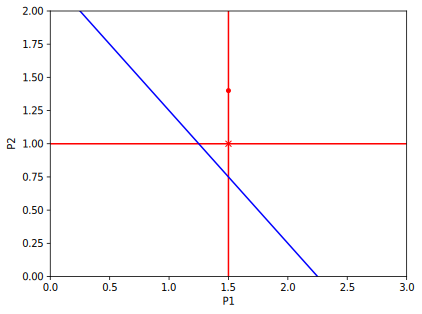

In [18]:
P01M = 1.5
P02M = 1
P1 = 1.5
P2 = 1.4
b01 = 1.25
b02 = 1

model = build_model(P01M, P02M, P1, P2, b01, b02)
print(solver.solve(model))
plot_results_frame(P01M, P02M,b01, b02)
plot_results(P1, P2, model.ls1.value, model.ls2.value, model.br.value, True, True)
print(model.ls1.value + model.ls2.value)


### grid results

In [19]:
P01M = 1
P02M =1
b01 = 1
b02 = 2

nb = 30
coef = 2
result = [[(0, 0) for _ in range(nb + 1)] for _ in range(nb + 1)]
for i in range(nb + 1):
    for j in range(nb + 1):
        P1 = coef * P01M * i / nb
        P2 = coef * P02M * j / nb
        model = build_model(P01M, P02M, P1, P2, b01, b02)
        solver.solve(model)
        result[i][j] = (P1, P2, model.ls1.value, model.ls2.value, model.br.value)

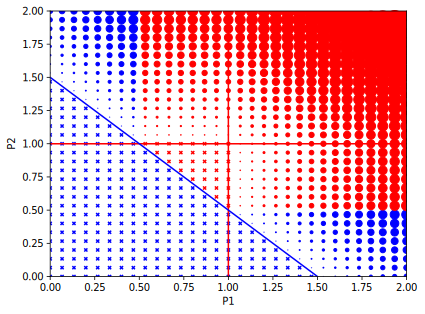

In [22]:
plot_results_frame(P01M, P02M,b01, b02)
for i in range(nb + 1):
    for j in range(nb + 1):
        P1, P2, ls1, ls2, br = result[i][j]
        plot_results(P1, P2, ls1, ls2, br, True, False)
